# Assignment 3
Prepared by Talha Alvi and Farhan Wadia

## Exercise 1 (Programming Exercise)

### Data

In [2]:
import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest
import matplotlib.pyplot as plt

depots = pd.read_csv("./carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("./carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("./carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

# Import a pre-calculated trip distance matrix
# These distances are based off of an osrm routing
tm = pd.read_csv("./trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Genetic Algorithm with 3 Vehicles

#### Solution Class

In [18]:
class GACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            print("Iter: ")
            print(x)
            print(" ")
            print(self.costs)
            self.states.append(max(self.costs))
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                sig = 1 - 0.9*(x/self.iterations)
                if random.random() < sig:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        # print("States:", self.states)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Solution

In [ ]:
from folium import Map, Marker, PolyLine, Icon
m = Map(location=pickup_nodes[0].coordinates[::-1], zoom_start=11)
bathurst_start = [43.82720773214452, -79.45379689449601]
bathurst_end = [43.636628218276, -79.3998242335392]
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
for x in pickup_nodes:
    if pickup_nodes.index(x) in second_vehicle_index:
        c  = "green"
    if pickup_nodes.index(x) in first_vehicle_index:
        c = "purple"
    if pickup_nodes.index(x) in third_vehicle_index:
        c = "red"
    Marker(location=x.coordinates[::-1], popup=x.coordinates, icon=Icon(color=c)).add_to(m)
PolyLine([bathurst_start, bathurst_end], color="red").add_to(m)
m


In [ ]:
first_vehicle_index = [0, 7, 8, 9]
second_vehicle_index = [2, 3,6]
third_vehicle_index = [4, 1, 5]
first_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in first_vehicle_index]
first_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in first_vehicle_index]
second_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in second_vehicle_index]
second_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in second_vehicle_index]
third_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in third_vehicle_index]
third_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in third_vehicle_index]


In [4]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7



In [19]:
solver = GACarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes, 
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
solver.initial_population()
solver.run()


Initial Population costs:
[12132.53, 5573.09, 2970.71, 4465.04, 5509.61, 10567.43, 5622.32, 7407.38, -2389.18, 9182.06, 1815.14, 956.84, 3565.4, 7295.06, 3146.36, 5984.03]
Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 93 ID: 4035051033]
Best Solution Profits: 18388.49
States: [12132.53, 12132.53, 12132.53, 12132.53, 12579.62, 12579.62, 14497.64, 16416.65, 16416.65

In [ ]:
first_solver = GACarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
first_solver.initial_population()
first_solver.run()

In [ ]:
second_solver = GACarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0]],
    post_avoid = [first_solver.solution[-1]])

# Initialize the population
second_solver.initial_population()
second_solver.run()

In [ ]:
third_solver = GACarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], second_solver.solution[0]],
    post_avoid = [first_solver.solution[-1], second_solver.solution[-1]])

# Initialize the population
third_solver.initial_population()
third_solver.run()

In [ ]:
print("Total profit: ",round(first_solver.solution_cost+second_solver.solution_cost+third_solver.solution_cost,2))

In [ ]:
first_map = first_solver.visualize_solution(prefix="A")
second_map = second_solver.visualize_solution(route_color="blue", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="green", m=second_map, prefix="C")
first_map

##### Visualization

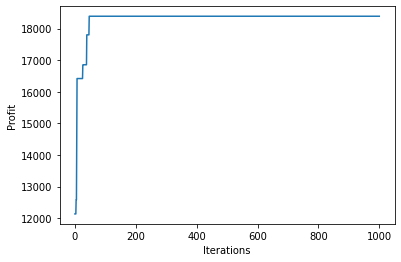

In [20]:
solver.visualize_graph()

In [ ]:
solver.visualize_solution()

### Adaptive Genetic Algorithm with 3 Vehicles

### Particle Swarm Optimization with 3 Vehicles

In [ ]:
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
import random

random.seed(21) # arbitrary random seed to make results reproducible

def argmax(lst):
    # From https://towardsdatascience.com/there-is-no-argmax-function-for-python-list-cd0659b05e49
    return max(zip(lst, range(len(lst))))[1]

class PSOCarSharingSolver:
    def __init__(self, depot_nodes, pickup_nodes, dropoff_nodes, trip_matrix, 
                 num_particles, num_swarms, iterations, pre_avoid = [], post_avoid = []):
        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.iterations = iterations
        self.num_particles = num_particles
        self.num_swarms = num_swarms
        self.particles = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        
    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
        
     # follow the leader of the local swarm
    def local_follow(population):
        for i in range(1, len(population)):
            population[i] = cross_over(population[0],population[i])

    # follow the global leader
    def global_follow():
        for u, v in itertools.product(range(0, len(leaders)), range(0, len(leaders))):
            to_be_mutated = random.choice([u, v])
            leaders[to_be_mutated] = cross_over(leaders[u], leaders[v])
    
    def add(self, position, velocity):
        # Swap position indices according to velocity pairs
        for element in velocity:
            tmp = position[element[0]]
            position[element[0]] = position[element[1]]
            position[element[1]] = tmp
        
        return position
    
    def subtract(self, posA, posB):
        # Calculate a velocity by doing posA - posB
        if len(posA) != len(posB):
            raise Exception("Positions need to be same length")
        
        velocity = []
        for i in range(len(posA)):
            if posA[i] != posB[i]:
                velocity.append([posA[i], posB[i]])
        
        return velocity
    
    def multiply(self, c, velocity):
        # Multiply a velocity by a constant
        if c == 0:
            return []
        elif c > 0 and c < 1:
            return velocity[:round(c*len(velocity))]
        elif c > 1:
            return velocity*(c // 1) + multiply(c % 1, velocity)
        else:
            raise Exception("Constant is not valid value.")
        
    
    def initial_particles(self):
        self.particles = [self.random_solution() for _ in range(self.num_particles)]
        self.costs = self.fitness(self.particles)

    # Single vehicle PSO
    def run(self):
        # Check that initial particles exist:
        if self.particles:
            # Show some information
            print("Initial Particles costs:")
            print(self.costs)
        else:
            raise Exception("Particles not initialized.")
        
        #Initialize particle velocities
        velocities = [[[0, 0]] for i in range(self.num_particles)]
        
        c1 = 1.4944
        c2 = 1.4944
        r1 = random.random()
        r2 = random.random()
        w = 0.792
        
        for iter_count in range(self.iterations):
            #self.costs = self.fitness(self.particles)
            #self.states.append(max(self.costs))
            
            #Segment particles into swarms
            pps = self.num_particles // self.num_swarms # particles per swarm
            swarms = list()
            for i in range(self.num_swarms):
                swarms.append(self.particles[i * (pps): i*(pps) + pps])
            
            # Calculate best fitness for each particle, each swarm, and global
            pBests_netProfit = self.fitness(self.particles)
            nBests_netProfit = [max(self.fitness(swarm)) for swarm in swarms]
            gBest_netProfit = max(nBests_netProfit)
            
            if iter_count == 0:
                pBests = self.particles
            
            nBests = [swarm[argmax(self.fitness(swarm))] for swarm in swarms]
            gBest = self.particles[argmax(self.fitness(self.particles))]
            
            print("pBests_netProfit:", pBests_netProfit)
            print("nBests_netProfit:", nBests_netProfit)
            print("gBest_netProfit:", gBest_netProfit)
            
            print("nBests:", nBests)
            print("gBest:", gBest)
            
            # Iterate over particles to update particle velocities and positions
            # Update nBest at the end of this iteration (synchronous PSO)
            for i, swarm in enumerate(swarms):
                for j, particle in enumerate(swarm):
                    inertial_velocity = self.multiply(w, velocities[j])
                    cognitive_velocity = self.multiply(c1*r1, self.subtract(pBests[j], particle))
                    social_velocity = self.multiply(c2*r2, self.subtract(nBests[i], particle))
                    
                    print("Inertia:", inertial_velocity)
                    
                
                #particle = particle + inertia + cognitive + social
  
            

            
            
            #for swarm in swarms:
            #    nBests = [0 for i in range(0, self.num_swarms)]
            
            
            #for swarm in swarms:
                #print("Swarm fitness:", self.fitness(swarm))
                #for pCount, particle in enumerate(swarm):
                #    print("Particle:\n", particle, "\n")
                    #print("Cost:", self.fitness(swarm[pCount]))
            #print("nbest", nBests)
            
            # We select the best particles in each swarm to lead
            leaders = particles[:pps][:]
            
            #for i in range(num_swarms):
            #    particles[i] , particles[i * (pps) - 1] = particles[i * (pps) - 1], particles[i]
    
            

            # For each swarm, we need to follow the leader of that swarm
            for swarm in swarms:
                local_follow(swarm)
    
            global_follow()

            # Add the new leaders
            particles[i*(pps-1)] = leaders[i]

            # Track the lowest cost in each swarm
            swarms = list()
            for i in range(self.num_swarms):
                swarms.append(particles[i * (pps): i*(pps) + pps])

            cost_set = []
            for swarm in swarms:
                lowest =min([cost(G,p) for p in swarm])
                cost_set.append(lowest)
            swarm_costs.append(cost_set)
            
            
            # Select the parents, we want to maximize the profit
            #parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            #parents = [x[1:-1] for x in parents]
            #offspring = []
            #new_population = []
            #for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
            #    # Crossover probability
            #    if random.random() < self.crossover_prob:
            #        offspring.append(GACarSharingSolver.crossover(p1,p2))
            #        offspring.append(GACarSharingSolver.crossover(p2,p1))
            #    else:
            #        offspring.append(p1)
            #        offspring.append(p2)
            #for child in offspring:
            #    if random.random() < self.mutation_prob:
            #        new_population.append(GACarSharingSolver.mutation(child))
            #    else:
            #        new_population.append(child)
            #new_population.extend(parents)
            #self.population = [self.find_depots(route) for route in new_population]

            
            
            
            
            
            
        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

In [ ]:
pop_size = 16
iterations = 1000
#num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

solver = PSOCarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix,
    num_particles=20,
    num_swarms=4, 
    iterations=1000)

solver.initial_particles()
solver.run()

In [ ]:
self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        num_particles,
        num_swarms,
        iterations,
        num_parents,
        pre_avoid = [],
        post_avoid = []

### Adaptive Particle Swarm Optimization with 3 Vehicles

### Comparison of Algorithms

Conduct a comparative analysis on genetic algorithm, adaptive genetic algorithm, swarm intelligence algorithm and adaptive swarm intelligence algorithm in terms of the generated profit, CPU times and Wall time spent in getting the solutions.